# COMP47670 Assignment 1: Data Collection & Preparation
## Name: Sam Lynch
## Student Number: 18492544
# Task 2

This notebook contains data preparation and analysis of the league standings, matches, and top goalscorers for the top 5 leagues in Europe: Engligh Premier League; Spanish Primera Division; German Bundesliga; French Ligue 1; and Italian Serie A, over the 2020/21 (impacted by COVID-19) and the 2021/22 seasons.

The JSON data collected in Task 1 will be used to perform the analysis

In [1]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
from IPython.core.display import HTML
import numpy as np
%matplotlib inline

Key settings, including the list of league codes and their corresponding league names, and appearance settings arre configured.

In [2]:
# League Codes
league_codes = ["PL","PD","BL1","FL1","SA"]
# Names of each league
leagues = {"PL":"Premier League","PD":"Primera Division","BL1":"Bundesliga","FL1":"Ligue 1","SA":"Serie A"}
pd.set_option('display.precision', 2)
# Colors that we will use in various plots
league_colours = {"PL":"navy", "PD":"darkred", "BL1":"red", "FL1":"blue", "SA": "green"}
# Default font size
fontsize = 13

Directories for data storage.

In [3]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

## Data Preprocessing

Data is transformed into a usable format for analysis.

Find all raw JSON data files and separate by league

In [4]:
league_files = {}
data_types = ["matches","standings","scorers"]
for league in league_codes:
    league_files[league] = {}
    for data_type in data_types:
        league_files[league][data_type] = []
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("_")
        if parts[0] in league_codes:
            league_files[parts[0]][parts[1]].append(fpath)

for league in league_codes:
    files_per_league = 0
    for data_type in data_types:
        files_per_league += len(league_files[league][data_type])
    print("%s: Found %d raw data files" % (leagues[league], files_per_league))

Premier League: Found 6 raw data files
Primera Division: Found 6 raw data files
Bundesliga: Found 6 raw data files
Ligue 1: Found 6 raw data files
Serie A: Found 6 raw data files


## Data Parsing and Merging

A function is written to parse an individual raw JSON data file from the Football Data API for each data type: standings; matches; and scorers.

Function to facilitate the display of images in a data frame.

In [5]:
def to_img_tag(path):
    return '<img src="'+ path + '" width="30" >'

In [6]:
def parse_raw_standings(fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    parts = fpath.stem.split("_")
    league_code = parts[0]
    season = int(parts[2])
    data = json.loads(jdata)
    table = []
    hometable = []
    awaytable = []
    typetable = 3
    for standing in data["standings"]:
        if standing["type"] == "TOTAL":
            typetable = 0 
        elif standing["type"] == "HOME":
            typetable = 1
        elif standing["type"] == "AWAY":
            typetable = 2 
        for club in standing["table"]:
            row = {"Crest" : club["team"]["crest"]}
            row["Name"] = club["team"]["name"]
            row["Games Played"] = club["playedGames"]
            row["Won"] = club["won"]
            row["Drawn"] = club["draw"]
            row["Lost"] = club["lost"]
            row["Goals For"] = club["goalsFor"]
            row["Goals Against"] = club["goalsAgainst"]
            row["Goal Difference"] = row["Goals For"] - row["Goals Against"]
            row["Points"] = club["points"]
            if typetable == 0:
                table.append(row)
            elif typetable == 1:
                hometable.append(row)
            elif typetable == 2:
                awaytable.append(row)
    fin.close()
    fulltable = pd.DataFrame(table)
    fulltable.index += 1
    
    home = pd.DataFrame(hometable)
    home.index += 1
    
    away = pd.DataFrame(awaytable)
    away.index += 1
    return fulltable, home, away

Function to calculate the age of a goal scorer on the final day of the respective season.

In [7]:
def age_from_dob(dob, end_of_season):
    dob = datetime.strptime(dob, '%Y-%m-%d')
    end_of_season = datetime.strptime(end_of_season, '%Y-%m-%d')
    age = (end_of_season - dob).days // 365
    
    return age

In [8]:
def parse_raw_scorers(fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    parts = fpath.stem.split("_")
    league_code = parts[0]
    season = int(parts[2])
    data = json.loads(jdata)
    end_of_season = data["season"]["endDate"]
    scorers = []
    for player in data["scorers"]:
        scorer = {"Name": player["player"]["name"]}
        scorer["Team"] = player["team"]["name"]
        scorer["Team_Crest"] = player["team"]["crest"]
        scorer["Age"] = age_from_dob(player["player"]["dateOfBirth"],end_of_season)
        scorer["Goals"] = player["goals"]
        if player["penalties"] is None:
            scorer["Non-Penalty Goals"] = scorer["Goals"]
        else:
            scorer["Non-Penalty Goals"] = int(scorer["Goals"]) - int(player["penalties"])
        if player["assists"] is None:
            scorer["Goal Contributions"] = scorer["Goals"]
            scorer["Assists"] = 0
        else:
            scorer["Assists"] = int(player["assists"])
            scorer["Goal Contributions"] = int(scorer["Goals"]) + int(scorer["Assists"])
        scorers.append(scorer)
        
    fin.close()
    topscorers = pd.DataFrame(scorers)
    topscorers.index += 1
    return topscorers

In [9]:
def parse_raw_matches(fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    parts = fpath.stem.split("_")
    league_code = parts[0]
    season = int(parts[2])
    data = json.loads(jdata)
    matches = []
    for game in data["matches"]:
        match = {"Matchday": game["matchday"], "Home": game["homeTeam"]["name"], "Away": game["awayTeam"]["name"]}
        match["Winner"] = game["score"]["winner"]
        match["FT Home Goals"] = int(game["score"]["fullTime"]["home"])
        match["FT Away Goals"] = int(game["score"]["fullTime"]["away"])
        match["HT Home Goals"] = game["score"]["halfTime"]["home"]
        match["HT Away Goals"] = game["score"]["halfTime"]["away"]
        if match["HT Home Goals"] is None:
            match["HT Home Goals"] = 0
        else:
            match["HT Home Goals"] = int(game["score"]["halfTime"]["home"])
        if  match["HT Away Goals"] is None:
            match["HT Away Goals"] = 0
        else:
            match["HT Away Goals"] = int(game["score"]["halfTime"]["away"]) 
        if  match["HT Home Goals"] > match["HT Away Goals"]:
            match["HT Leader"] = "HOME_TEAM"
        elif match["HT Home Goals"] < match["HT Away Goals"]:
            match["HT Leader"] = "AWAY_TEAM"
        else:
            match["HT Leader"] = "DRAW"
        for referee in game["referees"]:
            match["Referee"] = referee["name"]
        matches.append(match)
    seasongames = pd.DataFrame(matches)
    return seasongames

Parameters for the seasons and data types analysed.

In [10]:
seasons = ["2020","2021"]
data_types = ["matches","standings","scorers"]

Parse the raw data files for each league, season and data_type, producing a single merged Pandas Data Frame for each, which can be analysed.

In [11]:
df_leagues = {}
for league in league_codes:
    print("-- %s" % leagues[league])
    df_leagues[league] = {}
    index=0
    for data_type in data_types:
        df_leagues[league][data_type] = {}
        index = 0
        for season in seasons:
            fpath = league_files[league][data_type][index]
            if data_type == "standings":
                df_leagues[league][data_type][season] = {}
                df_fulltable, df_home, df_away = parse_raw_standings(fpath)
                df_leagues[league][data_type][season]["Full"] = df_fulltable
                df_leagues[league][data_type][season]["Home"] = df_home
                df_leagues[league][data_type][season]["Away"] = df_away
                print("Read and parsed {} {} data".format(season, data_type))
            elif data_type == "matches":
                df_games = parse_raw_matches(fpath)
                df_leagues[league][data_type][season] = df_games
                print("Read and parsed {} {} data".format(season, data_type))
            else:
                df_scorers = parse_raw_scorers(fpath)
                df_leagues[league][data_type][season] = df_scorers
                print("Read and parsed {} {} data".format(season, data_type))
            index += 1

-- Premier League
Read and parsed 2020 matches data
Read and parsed 2021 matches data
Read and parsed 2020 standings data
Read and parsed 2021 standings data
Read and parsed 2020 scorers data
Read and parsed 2021 scorers data
-- Primera Division
Read and parsed 2020 matches data
Read and parsed 2021 matches data
Read and parsed 2020 standings data
Read and parsed 2021 standings data
Read and parsed 2020 scorers data
Read and parsed 2021 scorers data
-- Bundesliga
Read and parsed 2020 matches data
Read and parsed 2021 matches data
Read and parsed 2020 standings data
Read and parsed 2021 standings data
Read and parsed 2020 scorers data
Read and parsed 2021 scorers data
-- Ligue 1
Read and parsed 2020 matches data
Read and parsed 2021 matches data
Read and parsed 2020 standings data
Read and parsed 2021 standings data
Read and parsed 2020 scorers data
Read and parsed 2021 scorers data
-- Serie A
Read and parsed 2020 matches data
Read and parsed 2021 matches data
Read and parsed 2020 stand

## Data Verification

Check the format of the data parsed.

Display the league standings for the English Premier League in the 2021/22 season, to verify league standings data.

In [12]:
display(HTML(df_leagues["PL"]["standings"]["2021"]["Full"].to_html(escape=False,formatters=dict(Crest=to_img_tag))))

,Crest,Name,Games Played,Won,Drawn,Lost,Goals For,Goals Against,Goal Difference,Points
1,,Manchester City FC,38,29,6,3,99,26,73,93
2,,Liverpool FC,38,28,8,2,94,26,68,92
3,,Chelsea FC,38,21,11,6,76,33,43,74
4,,Tottenham Hotspur FC,38,22,5,11,69,40,29,71
5,,Arsenal FC,38,22,3,13,61,48,13,69
6,,Manchester United FC,38,16,10,12,57,57,0,58
7,,West Ham United FC,38,16,8,14,60,51,9,56
8,,Leicester City FC,38,14,10,14,62,59,3,52
9,,Brighton & Hove Albion FC,38,12,15,11,42,44,-2,51
10,,Wolverhampton Wanderers FC,38,15,6,17,38,43,-5,51


Display the Top 10 Goal Scorers for the Spanish Primera Division in the 2020/21 season, to verify goal scorer data.

In [13]:
display(HTML(df_leagues["PD"]["scorers"]["2020"].to_html(escape=False,formatters=dict(Team_Crest=to_img_tag))))

,Name,Team,Team_Crest,Age,Goals,Non-Penalty Goals,Assists,Goal Contributions
1,Lionel Messi,FC Barcelona,,33,30,27,9,39
2,Gerard Moreno,Villarreal CF,,29,23,13,7,30
3,Karim Benzema,Real Madrid CF,,33,23,22,9,32
4,Luis Suárez,Club Atlético de Madrid,,34,21,18,3,24
5,Youssef En-Nesyri,Sevilla FC,,23,18,18,0,18
6,Alexander Isak,Real Sociedad de Fútbol,,21,16,16,2,18
7,Iago Aspas,RC Celta de Vigo,,33,14,9,13,27
8,José Luis Morales,Levante UD,,33,13,13,3,16
9,Rafael Mir,SD Huesca,,23,13,11,1,14
10,Antoine Griezmann,FC Barcelona,,30,13,12,7,20


Display the 10 games with the most home goals in the German Bundesliga in the 2021/22 season and the 10 games with the most away goals in the French Ligue 1 in the 2020/21 season, to verify the matches data.

In [14]:
df_leagues["BL1"]["matches"]["2021"].sort_values(by="FT Home Goals", ascending = False).head(10)

,Matchday,Home,Away,Winner,FT Home Goals,FT Away Goals,HT Home Goals,HT Away Goals,HT Leader,Referee
37,5,FC Bayern München,VfL Bochum 1848,HOME_TEAM,7,0,4,0,HOME_TEAM,Tobias Welz
118,14,Bayer 04 Leverkusen,SpVgg Greuther Fürth 1903,HOME_TEAM,7,1,3,1,HOME_TEAM,Tobias Reichel
205,23,Borussia Dortmund,Borussia Mönchengladbach,HOME_TEAM,6,0,2,0,HOME_TEAM,Marco Fritz
46,6,RB Leipzig,Hertha BSC,HOME_TEAM,6,0,3,0,HOME_TEAM,Sascha Stegemann
261,30,Borussia Dortmund,VfL Wolfsburg,HOME_TEAM,6,1,5,0,HOME_TEAM,Robert Schröder
134,15,Eintracht Frankfurt,Bayer 04 Leverkusen,HOME_TEAM,5,2,2,2,DRAW,Marco Fritz
162,19,Borussia Dortmund,SC Freiburg,HOME_TEAM,5,1,3,0,HOME_TEAM,Florian Badstübner
24,3,FC Bayern München,Hertha BSC,HOME_TEAM,5,0,2,0,HOME_TEAM,Sven Jablonski
300,34,Borussia Mönchengladbach,TSG 1899 Hoffenheim,HOME_TEAM,5,1,3,1,HOME_TEAM,Harm Osmers
172,20,Bayer 04 Leverkusen,FC Augsburg,HOME_TEAM,5,1,2,0,HOME_TEAM,Daniel Schlager


In [15]:
df_leagues["FL1"]["matches"]["2020"].sort_values(by="FT Away Goals", ascending = False).head(10)

,Matchday,Home,Away,Winner,FT Home Goals,FT Away Goals,HT Home Goals,HT Away Goals,HT Leader,Referee
206,21,AS Saint-Étienne,Olympique Lyonnais,AWAY_TEAM,0,5,0,2,AWAY_TEAM,Benoît Bastien
169,18,FC Lorient,AS Monaco FC,AWAY_TEAM,2,5,1,1,DRAW,Frank Schneider
364,37,Nîmes Olympique,Olympique Lyonnais,AWAY_TEAM,2,5,1,3,AWAY_TEAM,Ruddy Buquet
94,10,Nîmes Olympique,Angers SCO,AWAY_TEAM,1,5,0,2,AWAY_TEAM,William Lavis
346,35,Dijon Football Côte d'Or,FC Metz,AWAY_TEAM,1,5,0,2,AWAY_TEAM,Frank Schneider
234,24,Nîmes Olympique,AS Monaco FC,AWAY_TEAM,3,4,2,2,DRAW,Clément Turpin
150,16,OGC Nice,Olympique Lyonnais,AWAY_TEAM,1,4,1,2,AWAY_TEAM,Antony Gautier
256,26,FC Lorient,Lille OSC,AWAY_TEAM,1,4,1,2,AWAY_TEAM,Johan Hamel
261,27,Dijon Football Côte d'Or,Paris Saint-Germain FC,AWAY_TEAM,0,4,0,2,AWAY_TEAM,Mikael Lesage
124,13,FC Nantes,RC Strasbourg Alsace,AWAY_TEAM,0,4,0,2,AWAY_TEAM,Clément Turpin


Display the league standings for home matches in the Italian Serie A in the 2021/22 season, to verify league standings data.

In [16]:
display(HTML(df_leagues["SA"]["standings"]["2021"]["Away"].to_html(escape=False,formatters=dict(Crest=to_img_tag))))

,Crest,Name,Games Played,Won,Drawn,Lost,Goals For,Goals Against,Goal Difference,Points
1,,AC Milan,19,14,4,1,41,19,22,46
2,,SSC Napoli,19,13,4,2,37,15,22,43
3,,FC Internazionale Milano,19,11,6,2,36,16,20,39
4,,Atalanta BC,19,12,3,4,34,19,15,39
5,,Juventus FC,19,10,5,4,32,23,9,35
6,,SS Lazio,19,8,4,7,35,33,2,28
7,,AS Roma,19,8,3,8,33,27,6,27
8,,US Sassuolo Calcio,19,7,5,7,37,36,1,26
9,,Empoli FC,19,6,6,7,22,26,-4,24
10,,Hellas Verona FC,19,5,8,6,31,34,-3,23


Check to see if there is any missing values in any of the Data Frames.

In [17]:
for league in league_codes:
    print("-- %s" % leagues[league])
    missing_counts = 0
    for data_type in data_types:
        for season in seasons:
            if data_type == "standings":
                missing_counts += df_leagues[league][data_type][season]["Full"].isnull().sum()
                missing_counts += df_leagues[league][data_type][season]["Home"].isnull().sum()
                missing_counts += df_leagues[league][data_type][season]["Away"].isnull().sum()
            else:
                missing_counts += df_leagues[league][data_type][season].isnull().sum()
            # Which columns have missing values?data_type
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print("There are {} missing values".format(missing_counts))

-- Premier League
No missing values found
-- Primera Division
No missing values found
-- Bundesliga
No missing values found
-- Ligue 1
No missing values found
-- Serie A
No missing values found


# Data Saving

Now write out all of the merged league DataFrames in JSON forma. These will represent the 'clean' data that we will use next for our actual data analysis:

In [18]:
for league in league_codes:
    for data_type in data_types:
        for season in seasons:
            if data_type == "standings":
                fname = "{}_{}_{}_Full.json".format(league, season, data_type)
                out_path = dir_data / fname
                print("Writing %s" % out_path)
                df_leagues[league][data_type][season]["Full"].to_json(out_path, orient = "index", indent=4)
                fname = "{}_{}_{}_Home.json".format(league, season, data_type)
                out_path = dir_data / fname
                print("Writing %s" % out_path)
                df_leagues[league][data_type][season]["Home"].to_json(out_path, orient = "index", indent=4)
                fname = "{}_{}_{}_Away.json".format(league, season, data_type)
                out_path = dir_data / fname
                print("Writing %s" % out_path)
                df_leagues[league][data_type][season]["Away"].to_json(out_path, orient = "index", indent=4)
            else:
                fname = "{}_{}_{}.json".format(league, season, data_type)
                out_path = dir_data / fname
                print("Writing %s" % out_path)
                df_leagues[league][data_type][season].to_json(out_path, orient = "index", indent=4)

Writing data\PL_2020_matches.json
Writing data\PL_2021_matches.json
Writing data\PL_2020_standings_Full.json
Writing data\PL_2020_standings_Home.json
Writing data\PL_2020_standings_Away.json
Writing data\PL_2021_standings_Full.json
Writing data\PL_2021_standings_Home.json
Writing data\PL_2021_standings_Away.json
Writing data\PL_2020_scorers.json
Writing data\PL_2021_scorers.json
Writing data\PD_2020_matches.json
Writing data\PD_2021_matches.json
Writing data\PD_2020_standings_Full.json
Writing data\PD_2020_standings_Home.json
Writing data\PD_2020_standings_Away.json
Writing data\PD_2021_standings_Full.json
Writing data\PD_2021_standings_Home.json
Writing data\PD_2021_standings_Away.json
Writing data\PD_2020_scorers.json
Writing data\PD_2021_scorers.json
Writing data\BL1_2020_matches.json
Writing data\BL1_2021_matches.json
Writing data\BL1_2020_standings_Full.json
Writing data\BL1_2020_standings_Home.json
Writing data\BL1_2020_standings_Away.json
Writing data\BL1_2021_standings_Full.jso

# Data Analysis

# League Standings Analysis

First, the league standings data is analysed. 

A function is created to compute the statistics for a specific column of data.

In [19]:
def compute_league_stats(season, table_type, column):
    rows = []
    for league in league_codes:
        row = {"League": league}
        row["Min"] = df_leagues[league]["standings"][season][table_type][column].min()
        row["Max"] = df_leagues[league]["standings"][season][table_type][column].max()
        row["Mean"] = df_leagues[league]["standings"][season][table_type][column].mean()
        row["Median"] = df_leagues[league]["standings"][season][table_type][column].median()
        row["Sum"] = df_leagues[league]["standings"][season][table_type][column].sum()
        rows.append(row)
    return pd.DataFrame(rows).set_index("League")

The statistics for goals scored are computed for each league in each season.

In [20]:
df_goal_2021_stats = compute_league_stats("2021", "Full", "Goals For")
df_goal_2021_stats

,Min,Max,Mean,Median,Sum
League,,,,,
PL,23,99,53.55,49.0,1071
PD,31,80,47.55,43.0,951
BL1,27,97,53.00,50.0,954
FL1,35,90,53.35,50.5,1067
SA,27,84,54.45,58.0,1089


In [21]:
df_goal_2020_stats = compute_league_stats("2020", "Full", "Goals For")
df_goal_2020_stats

,Min,Max,Mean,Median,Sum
League,,,,,
PL,20,83,51.20,51.0,1024
PD,28,85,47.65,46.5,953
BL1,25,99,51.56,52.0,928
FL1,25,86,52.45,50.0,1049
SA,39,90,58.00,51.5,1160


As the Bundesliga teams play less games than the other leagues, the goals per game statistics must be calculated to ensure that the analysis is fair and consistent for each league.

In [22]:
mean_goals_per_game = {}
for league in df_goal_2020_stats.index:
    mean_goals_per_game[league] = {}
    # Note that the mean goals stat is multiplied by two to account for two teams playing in each game.
    mean_goals_per_game[league]["2021/22"] = df_goal_2021_stats["Mean"][league]*2/df_leagues[league]["standings"]["2021"]["Full"]["Games Played"].max()
    mean_goals_per_game[league]["2020/21"] = df_goal_2020_stats["Mean"][league]*2/df_leagues[league]["standings"]["2020"]["Full"]["Games Played"].max()
df_mean_goals_per_game = pd.DataFrame(mean_goals_per_game)
df_mean_goals_per_game

,PL,PD,BL1,FL1,SA
2021/22,2.82,2.50,3.12,2.81,2.87
2020/21,2.69,2.51,3.03,2.76,3.05


We plot the goals per game data to see which league is the most free scoring per season.

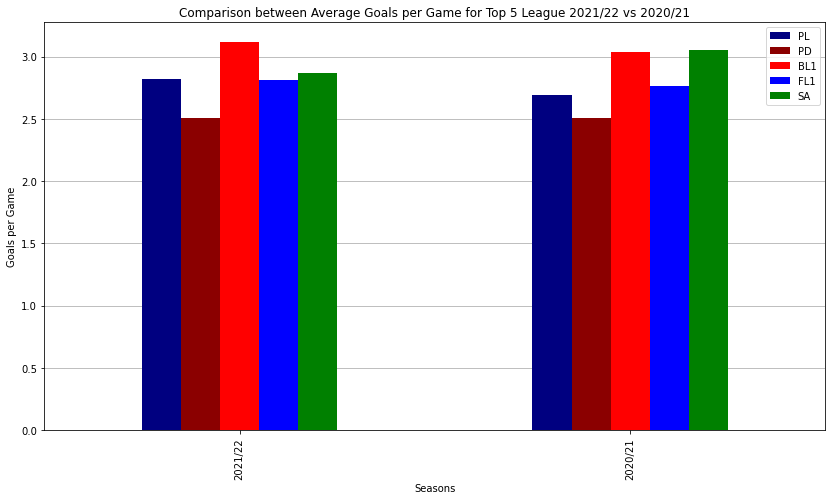

In [23]:
ax = df_mean_goals_per_game.plot.bar(figsize=(14,7.5), color = league_colours, zorder = 3)

ax.set_title("Comparison between Average Goals per Game for Top 5 League 2021/22 vs 2020/21")
ax.set_ylabel("Goals per Game")
ax.set_xlabel("Seasons")
ax.yaxis.grid(True)

This graph shows that in the 2021/22 season the Bundesliga produces the most goals per game, and in the 2020/21 season the Bundesliga and the Serie A produce the most goals per game. In both seasons, the Primera Division produces the least goals per game, so could be viewed as the least entertaining league.

The largest change in goals per game is seen in the decrease in the Serie A from the 2020/21 season to the 2021/22 season. 

The spread of goals scored per team in each league is viewed in the boxplots below.

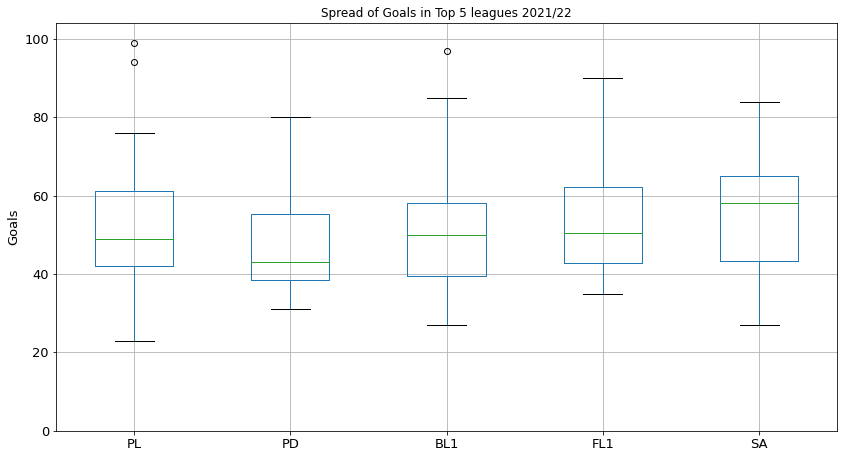

In [24]:
df_goals_per_team_2021 = {}
for league in league_codes:
    df_goals_per_team_2021[league] = {}
    df_goals_per_team_2021[league].update(zip(df_leagues[league]["standings"]["2021"]["Full"]["Name"],df_leagues[league]["standings"]["2021"]["Full"]["Goals For"]))
df_goals_2021 = pd.DataFrame(df_goals_per_team_2021)
ax = df_goals_2021.boxplot(figsize=(14,7.5), fontsize=fontsize)
ax.set_title("Spread of Goals in Top 5 leagues 2021/22")
ax.set_ylim(0, df_goal_2021_stats["Max"].max()+5)
ax.set_ylabel("Goals", fontsize=fontsize);

The lowest average is seen in the Primera Division, which is unsurprising considering the goals per game results. However, the lowest amount of goals scored by a team is in the Premier League. 

There are a number of outliers in the data, shown by high values for the Premier League and Bundesliga. These highlight the dominance of Liverpool and Manchester City in the Premier League, and the dominance of Bayern Munich in the Bundesliga.

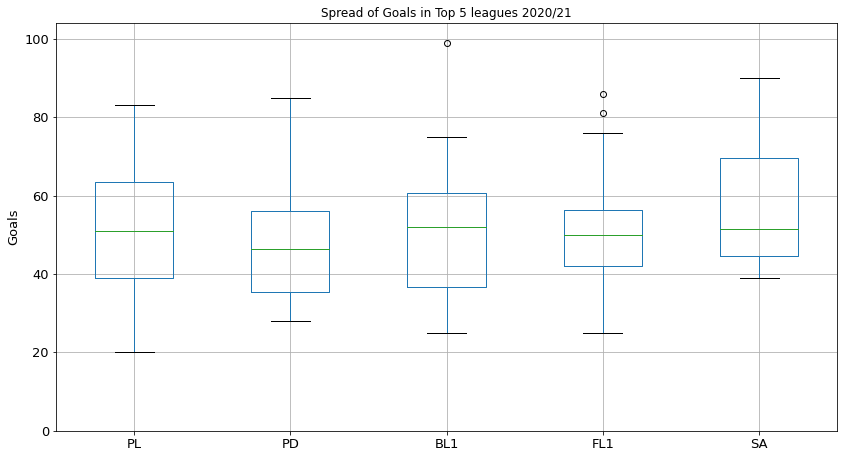

In [25]:
df_goals_per_team_2020 = {}
for league in league_codes:
    df_goals_per_team_2020[league] = {}
    df_goals_per_team_2020[league].update(zip(df_leagues[league]["standings"]["2020"]["Full"]["Name"],df_leagues[league]["standings"]["2020"]["Full"]["Goals For"]))
df_goals_2020 = pd.DataFrame(df_goals_per_team_2020)
ax = df_goals_2020.boxplot(figsize=(14,7.5), fontsize=fontsize)
ax.set_title("Spread of Goals in Top 5 leagues 2020/21")
ax.set_ylim(0, df_goal_2020_stats["Max"].max()+5)
ax.set_ylabel("Goals", fontsize=fontsize);

The lowest average is seen in the Primera Division, which is unsurprising considering the goals per game results. However, the lowest amount of goals scored by a team is, again,  in the Premier League. 

There is a significant outlier in the data, shown by the high value in the Bundesliga. This, again, highlights the dominance of Bayern Munich. It is interesting to see that there is no outliers for the Premier League, which shows that Manchester City and Liverpool were closer to the mean in terms of goals scored this season

The compute league stats function was used to calculate the statitstics for points won by teams in each league. Statistics were computed for each season for comparison purposes.

In [26]:
df_points_2021_stats = compute_league_stats("2021", "Full", "Points")
df_points_2021_stats

,Min,Max,Mean,Median,Sum
League,,,,,
PL,22,93,52.60,50.0,1052
PD,31,86,51.45,46.5,1029
BL1,18,77,46.94,45.5,845
FL1,31,86,51.90,51.5,1038
SA,27,86,52.10,50.0,1042


In [27]:
df_points_2020_stats = compute_league_stats("2020", "Full", "Points")
df_points_2020_stats

,Min,Max,Mean,Median,Sum
League,,,,,
PL,23,86,52.85,57.0,1057
PD,30,86,51.55,45.0,1031
BL1,16,78,46.50,45.0,837
FL1,21,83,52.25,46.5,1045
SA,20,91,52.05,42.0,1041


The points per game stats are calculated for the teams that came last place and first place in each league, for both seasons.

In [28]:
max_and_min_points_per_game = {}
for league in df_goal_2020_stats.index:
    max_and_min_points_per_game[league] = {}
    max_and_min_points_per_game[league]["1st 2021/22"] = df_points_2021_stats["Max"][league]/df_leagues[league]["standings"]["2021"]["Full"]["Games Played"].max()
    max_and_min_points_per_game[league]["1st 2020/21"] = df_points_2020_stats["Max"][league]/df_leagues[league]["standings"]["2020"]["Full"]["Games Played"].max()
    max_and_min_points_per_game[league]["Last 2021/22"] = df_points_2021_stats["Min"][league]/df_leagues[league]["standings"]["2021"]["Full"]["Games Played"].max()
    max_and_min_points_per_game[league]["Last 2020/21"] = df_points_2020_stats["Min"][league]/df_leagues[league]["standings"]["2020"]["Full"]["Games Played"].max()
df_max_and_min_points_per_game = pd.DataFrame(max_and_min_points_per_game)
df_max_and_min_points_per_game 

,PL,PD,BL1,FL1,SA
1st 2021/22,2.45,2.26,2.26,2.26,2.26
1st 2020/21,2.26,2.26,2.29,2.18,2.39
Last 2021/22,0.58,0.82,0.53,0.82,0.71
Last 2020/21,0.61,0.79,0.47,0.55,0.53


This is plotted for illustration.

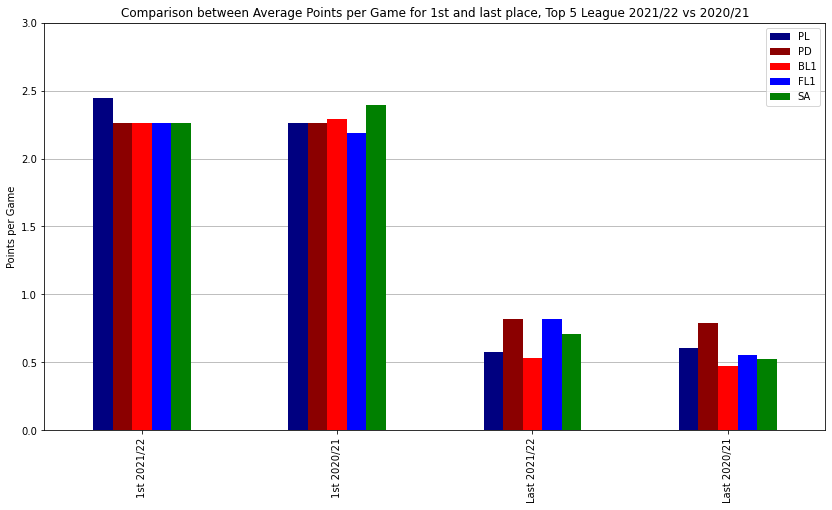

In [29]:
ax = df_max_and_min_points_per_game.plot.bar(figsize = (14,7.5), color = league_colours, zorder = 3)

ax.set_title("Comparison between Average Points per Game for 1st and last place, Top 5 League 2021/22 vs 2020/21")
ax.set_ylabel("Points per Game")
ax.set_ylim(0, 3)
ax.yaxis.grid(True)

In the 2021/22 season, the team that won the Premier League won by far the most points per game across the league winners, while the other leagues winners won the same amount of points per game as each other. In the 2020/21 season, however, the team that won the Serie A won the most points per game and the team who won the Ligue 1 won the least points per game among the league winners.

In the 2021/22 season, the "best losers", i.e. the team that came last place with the most points per game, were from the Primera Division and the Ligue 1. The "worst losers" were from the Bundesliga. In 2020/21, again the "best losers" were from the Primera Division and the "worst losers" were from the Bundesliga.

This suggests that the Primera Division may be the most even league and the Bundesliga shows the biggest disparity between first and last place.

## Home Advantage Analysis

The biggest difference between the 2021/22 and 2020/21 seasons is that the 2020/21 season was played "behind closed doors" meaning that there were no fans in the stadium for the games, while the fans were invited back into the stadiums in the 2021/22 season.

Therefore, we will study the difference between points won in home games for each season to look at the impact of the home fans in each league.

In [30]:
df_home_points_2021_stats = compute_league_stats("2021", "Home", "Points")
df_home_points_2021_stats 

,Min,Max,Mean,Median,Sum
League,,,,,
PL,8,49,28.85,29.0,577
PD,18,44,30.30,28.5,606
BL1,14,41,27.89,28.0,502
FL1,16,51,29.40,27.5,588
SA,14,45,27.10,26.5,542


In [31]:
df_home_points_2020_stats = compute_league_stats("2020", "Home", "Points")
df_home_points_2020_stats 

,Min,Max,Mean,Median,Sum
League,,,,,
PL,10,41,25.75,26.0,515
PD,13,48,29.15,30.0,583
BL1,12,43,26.00,27.0,468
FL1,9,41,26.05,25.0,521
SA,11,52,28.05,25.0,561


The points won per game are calculated to ensure the data is consistent across each league

In [32]:
home_points_per_game = {}
for league in df_goal_2020_stats.index:
    home_points_per_game[league] = {}
    home_points_per_game[league]["2021/22"] = df_home_points_2021_stats["Sum"][league]/(df_leagues[league]["standings"]["2021"]["Full"]["Games Played"].max()*10)
    home_points_per_game[league]["2020/21"] = df_home_points_2020_stats["Sum"][league]/(df_leagues[league]["standings"]["2020"]["Full"]["Games Played"].max()*10)
df_home_points_per_game = pd.DataFrame(home_points_per_game)
df_home_points_per_game 

,PL,PD,BL1,FL1,SA
2021/22,1.52,1.59,1.48,1.55,1.43
2020/21,1.36,1.53,1.38,1.37,1.48


The results are plotted for illustration.

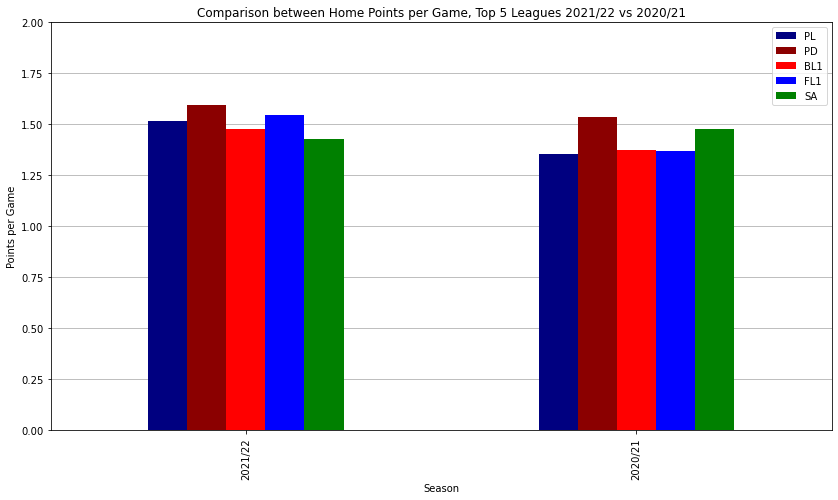

In [33]:
ax = df_home_points_per_game.plot.bar(figsize = (14,7.5), color = league_colours, zorder = 3)

ax.set_title("Comparison between Home Points per Game, Top 5 Leagues 2021/22 vs 2020/21")
ax.set_ylabel("Points per Game")
ax.set_xlabel("Season")
ax.set_ylim(0, 2)
ax.yaxis.grid(True)

This graph shows that playing in front of fans at home matches is a significant advantage across all the top leagues in Europe except for in the Serie A. 

This is illustrated as there is a significant increase in home points won per game in each league from the 2020/21 season to the 2021/22 season. This is not the case, however, in the Serie A as there is less home points won per game in 2021/22, in front of fans, than behind closed door in 2020/21.

### Correlation

In [34]:
import numpy as np
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(24, 12, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

C:\Users\samly\AppData\Local\Temp\ipykernel_2728\4274032422.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\4274032422.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\4274032422.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\4274032422.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values

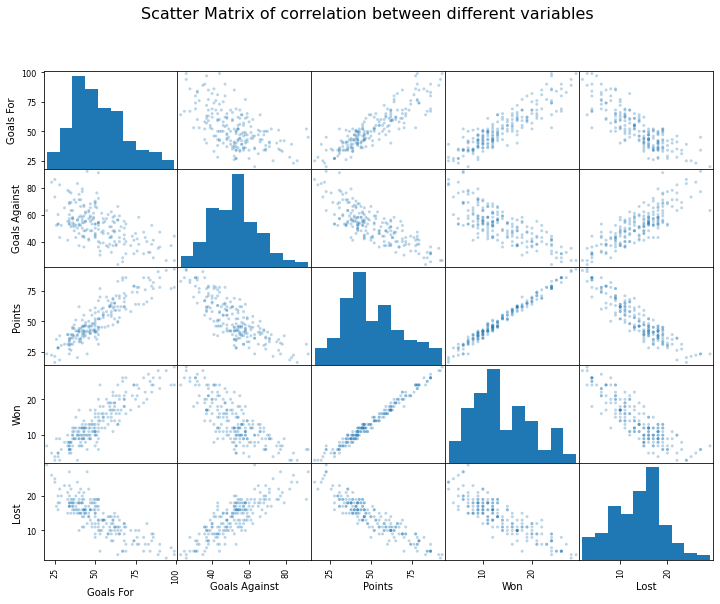

In [35]:
#Initialise the new DataFrame to store the values of the numeric variables
df_numeric_values = pd.DataFrame({})
for league in league_codes:
    for season in seasons:
    #Filter the numeric values from each artist in the artist DataFrame
        values = df_leagues[league]["standings"][season]["Full"].filter(["Goals For","Goals Against","Points","Won", "Lost"], axis=1)
        df_numeric_values = df_numeric_values.append(values)
    
#Plot the scatter matrix
ax = scatter_matrix(df_numeric_values, figsize=(12,9), alpha=0.3)
plt.suptitle("Scatter Matrix of correlation between different variables", fontsize = fontsize+3);

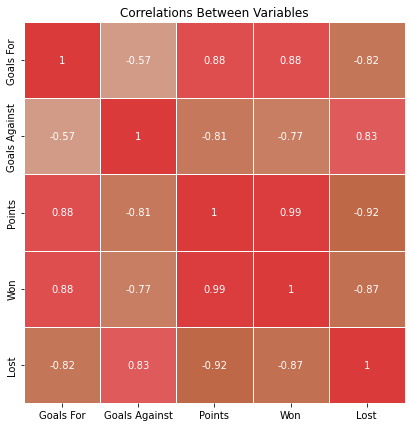

In [36]:
plot_heatmap("Correlations Between Variables", df_numeric_values, figsize=(11,7))

This shows there is a high correlation between goals for and wins (0.88) and goals against and losses (0.83) which is to be expected.

# Goalscorer Analysis

Next, the top goalscorer data is analysed, which includes data from the top 10 scorers in each league. 

A function is created to compute the statistics for a specific column of data.

In [37]:
def compute_scorer_stats(season, column):
    rows = []
    for league in league_codes:
        row = {"League": league}
        row["Min"] = df_leagues[league]["scorers"][season][column].min()
        row["Max"] = df_leagues[league]["scorers"][season][column].max()
        row["Mean"] = df_leagues[league]["scorers"][season][column].mean()
        rows.append(row)
    return pd.DataFrame(rows).set_index("League")

The statistics for the top goalscorer's ages ar computed using the function. 

In [38]:
df_age_scorers_2021 = compute_scorer_stats("2021", "Age")
df_age_scorers_2021

,Min,Max,Mean
League,,,
PL,25,37,29.9
PD,21,34,29.1
BL1,21,34,27.3
FL1,22,35,27.7
SA,22,36,27.0


In [39]:
df_age_scorers_2020 = compute_scorer_stats("2020", "Age")
df_age_scorers_2020

,Min,Max,Mean
League,,,
PL,24,34,27.9
PD,21,34,29.2
BL1,20,33,27.4
FL1,22,35,27.1
SA,21,36,28.2


It can be seen that in 2021/22 the oldest mean age of the top goalscorers (29.9) was in the Premier League and the youngest mean age of the top goalscorers (27) was in the Serie A. The oldest scorer was in the Premier League (37), the youngest goal scorers were in the Primera Division and the Bundesliga (21).

In 2020/21 the oldest mean age of the top goalscorers (29.2) was in the Primera Division and the youngest mean age of the top goalscorers (27.1) was in the Ligue 1. The oldest scorer was in the Serie A (36), the youngest goal scorers was in the Bundesliga (20).

The data is merged to one dataframe so that it can be plotted together.

In [40]:
def merge_data_by_column(season,col_name):
    columns = {}
    for league in league_codes:
        columns[league] = df_leagues[league]["scorers"][season][col_name]
    df_merged = pd.DataFrame(columns).sort_index()
    # note if we have some mismatches on dates between leagues, we will drop the rows
    return df_merged.dropna()

In [41]:
df_ages_merged_2021 = merge_data_by_column("2021", "Age")
df_ages_merged_2021

,PL,PD,BL1,FL1,SA
1,29,34,33,23,32
2,29,29,26,31,22
3,37,21,21,25,24
4,28,34,34,25,24
5,30,27,24,30,26
6,35,25,24,28,23
7,25,32,26,22,27
8,30,34,22,28,33
9,29,27,29,30,23
10,27,28,34,35,36


In [42]:
df_ages_merged_2020 = merge_data_by_column("2020", "Age")
df_ages_merged_2020

,PL,PD,BL1,FL1,SA
1,27,33,32,22,36
2,28,29,25,27,28
3,26,33,20,30,30
4,27,34,29,27,21
5,28,23,28,35,31
6,24,21,23,27,29
7,34,33,32,28,29
8,25,33,31,29,23
9,30,23,21,24,26
10,30,30,33,22,29


The age of each top scorer is plotted on serparate plots for each league.

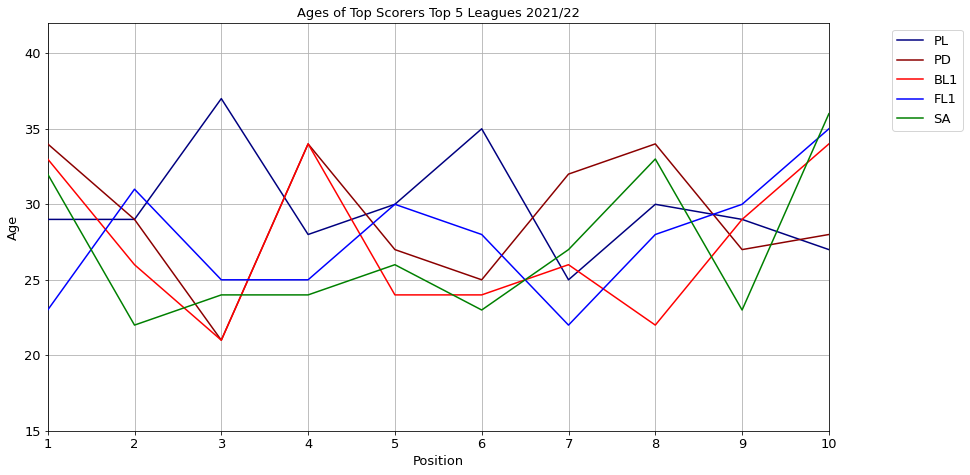

In [43]:
ax = df_ages_merged_2021.plot(figsize=(14,7.5), color=league_colours, fontsize=fontsize, zorder=3)
ax.set_title("Ages of Top Scorers Top 5 Leagues 2021/22", fontsize=fontsize)
ax.set_xlabel("Position", fontsize=fontsize)
ax.set_ylabel("Age", fontsize=fontsize)
# adjust the axis limits
ax.set_ylim(15, df_age_scorers_2021["Max"].max()+5)
ax.set_xlim(df_ages_merged_2021.index.min(), df_ages_merged_2021.index.max())    
# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True)
ax.yaxis.grid(True)

This clearly shows that Ligue 1 hosted the youngest top scorer in 2021/22 and the trend of the Premier Leagues was certainly the highest in terms of age.

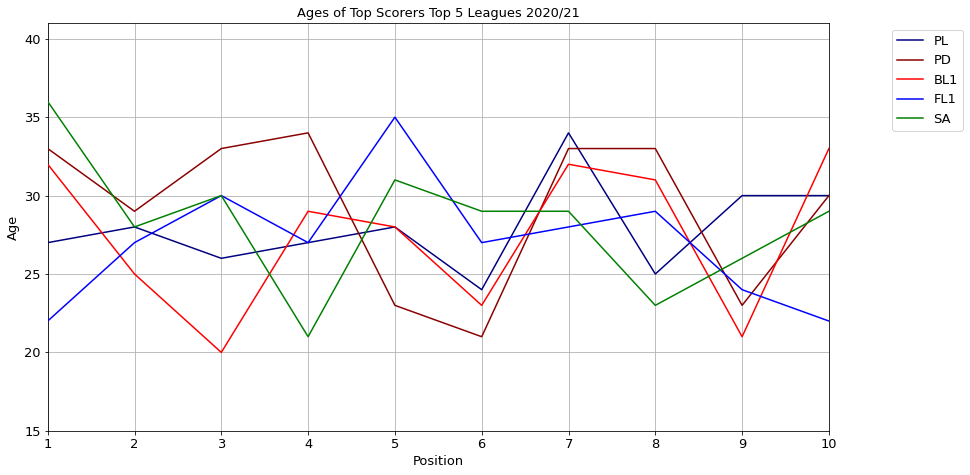

In [44]:
ax = df_ages_merged_2020.plot(figsize=(14,7.5), color=league_colours, fontsize=fontsize, zorder=3)
ax.set_title("Ages of Top Scorers Top 5 Leagues 2020/21", fontsize=fontsize)
ax.set_xlabel("Position", fontsize=fontsize)
ax.set_ylabel("Age", fontsize=fontsize)
# adjust the axis limits
ax.set_ylim(15, df_age_scorers_2020["Max"].max()+5)
ax.set_xlim(df_ages_merged_2020.index.min(), df_ages_merged_2020.index.max())    
# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True)
ax.yaxis.grid(True)

This clearly shows that, again, Ligue 1 hosted the youngest top scorer in 2020/21 and the trend of the Primera Division was certainly the highest in terms of age.

The goals scored are calculated for each age from 19-40 to analyse when goal-scorers tend to peak and players of what age scored the most goals each season.

In [45]:
def compute_goals_per_age(season):
    df_goals_per_age = {}
    for league in league_codes:
        group = df_leagues[league]["scorers"][season]["Goals"].groupby(df_leagues[league]["scorers"][season]["Age"]).sum()
        df_goals_per_age[league] = group
    ages = range(19,40)
    goals_per_age = []
    for age in ages:
        goals = 0
        for league in league_codes:
            if age in df_goals_per_age[league].keys():
                goals += df_goals_per_age[league][age]
        goals_per_age.append(goals)
    return pd.DataFrame({"Goals": goals_per_age},index = ages)

In [46]:
df_goals_per_age_2020_merged = compute_goals_per_age("2020")
df_goals_per_age_2020_merged

,Goals
19,0
20,27
21,48
22,41
23,64
24,30
25,42
26,35
27,93
28,99


This data is plotted for illustration.

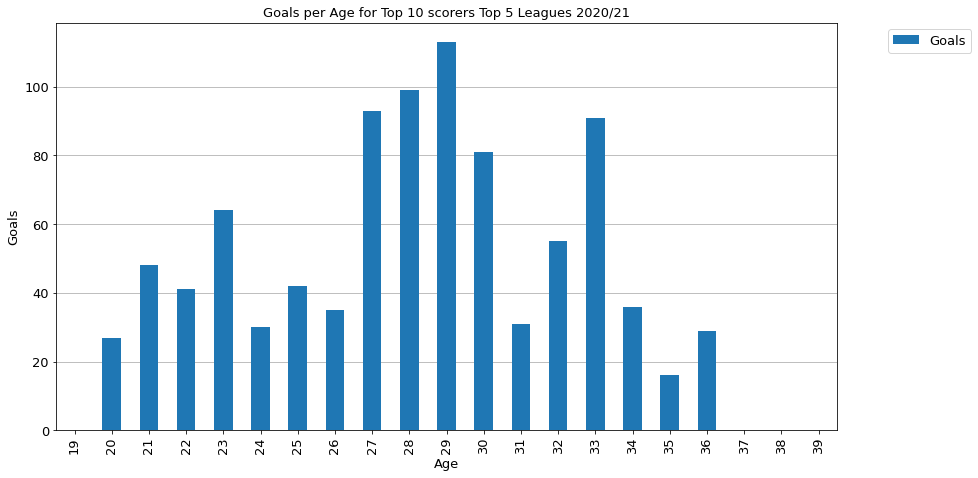

In [47]:
ax = df_goals_per_age_2020_merged.plot.bar(figsize=(14,7.5), fontsize=fontsize, zorder=3)
ax.set_title("Goals per Age for Top 10 scorers Top 5 Leagues 2020/21", fontsize=fontsize)
ax.set_xlabel("Age", fontsize=fontsize)
ax.set_ylabel("Goals", fontsize=fontsize) 
# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
ax.yaxis.grid(True)

This bar chat shows that players of age 29 scored the most goals in 2020/21, with players of age 27,28 and 33 not far behind. This suggests that players score the most amount of goals as they reach their late 20s/early 30s.

In [48]:
df_goals_per_age_2021_merged = compute_goals_per_age("2021")
df_goals_per_age_2021_merged

,Goals
19,0
20,0
21,39
22,52
23,59
24,73
25,73
26,55
27,57
28,58


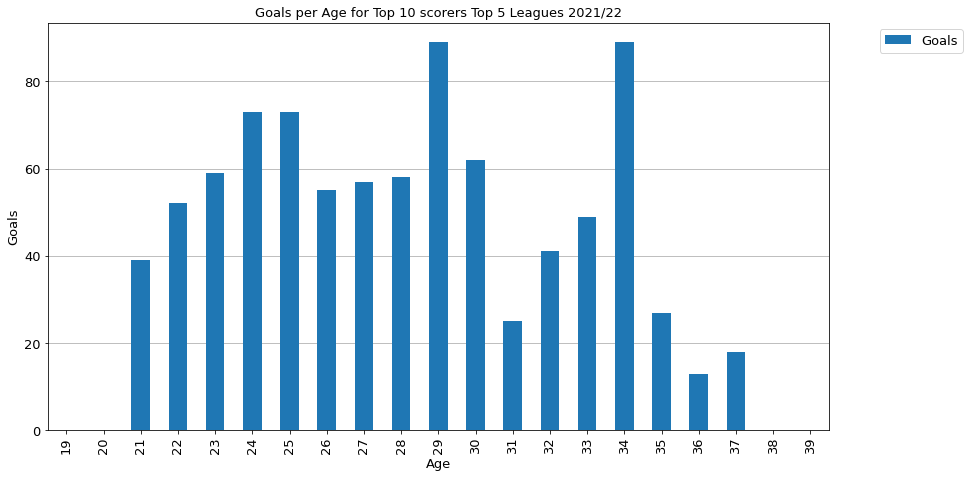

In [49]:
ax = df_goals_per_age_2021_merged.plot.bar(figsize=(14,7.5), fontsize=fontsize, zorder=3)
ax.set_title("Goals per Age for Top 10 scorers Top 5 Leagues 2021/22", fontsize=fontsize)
ax.set_xlabel("Age", fontsize=fontsize)
ax.set_ylabel("Goals", fontsize=fontsize) 
# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
ax.yaxis.grid(True)

In 2021/22 there were more goals scored by younger players than in the previous season, analysed above. However, the most goals were scored by 29 year olds and 34 year olds which supports the claim that goalscorers score their most goals in their late 20s/early 30s.

### Correlation

C:\Users\samly\AppData\Local\Temp\ipykernel_2728\181598339.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\181598339.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\181598339.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\181598339.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.app

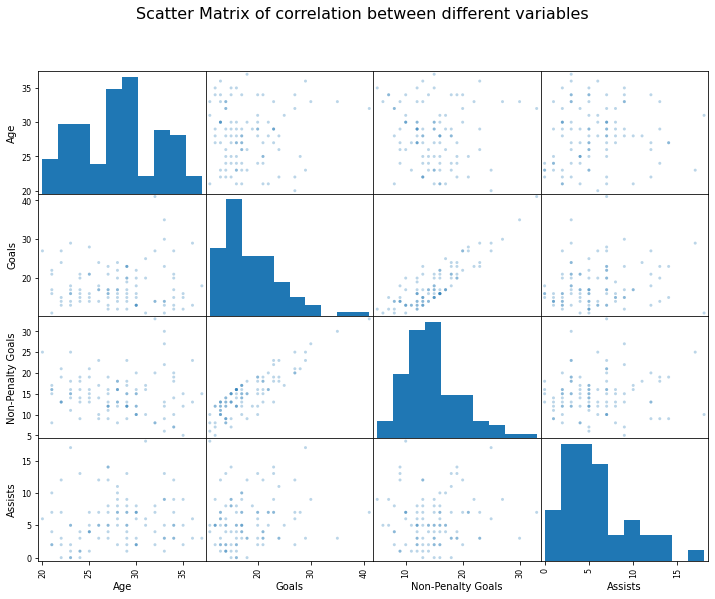

In [50]:
#Initialise the new DataFrame to store the values of the numeric variables
df_numeric_values = pd.DataFrame({})
for league in league_codes:
    for season in seasons:
    #Filter the numeric values from each artist in the artist DataFrame
        values = df_leagues[league]["scorers"][season].filter(["Age","Goals","Non-Penalty Goals","Assists"], axis=1)
        df_numeric_values = df_numeric_values.append(values)
    
#Plot the scatter matrix
ax = scatter_matrix(df_numeric_values, figsize=(12,9), alpha=0.3)
plt.suptitle("Scatter Matrix of correlation between different variables", fontsize = fontsize+3);

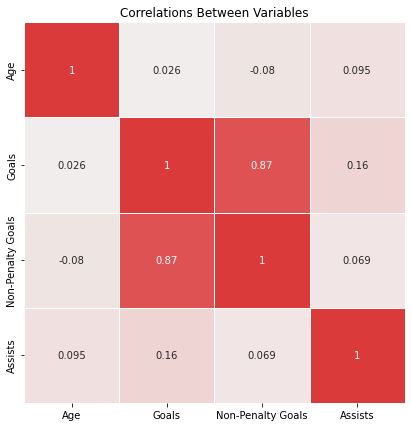

In [51]:
plot_heatmap("Correlations Between Variables", df_numeric_values, figsize=(11,7))

This shows there is very little correlation between any of the values except for the obvious correlation between Non-penalty goals and goals.

# League Matches Analysis

Next, the league matches data is analysed, which includes data every game in the studied leagues across the 2 seasons in focus. 

The Half-Time and Full-Time scores for each game are investigated to analyse which league season contained the most comebacks (teams recovering from losing at Half-Time to win or draw the match), and what scenario was the most frequent, e.g. Home team losing at Half-Time, winning at Full-Time, Away team losing at Half-Time, drawing at Full-Time etc.

In [52]:
comebacks = {}
comebacks["Home loss to win"] = {}
comebacks["Home loss to draw"] = {}
comebacks["Away loss to win"] = {}
comebacks["Away loss to draw"] = {}
comebacks["Sum"] = {}
for league in league_codes:
    for season in seasons:
        comebacks["Home loss to win"]["{}_{}".format(league,season)] = 0
        comebacks["Home loss to draw"]["{}_{}".format(league,season)] = 0
        comebacks["Away loss to win"]["{}_{}".format(league,season)] = 0
        comebacks["Away loss to draw"]["{}_{}".format(league,season)] = 0
        Winners = df_leagues[league]["matches"][season]["Winner"].values
        HT_Leaders = df_leagues[league]["matches"][season]["HT Leader"].values
        for Winner, HT_Leader in zip(Winners, HT_Leaders):
            if HT_Leader == "AWAY_TEAM":
                if Winner == "HOME_TEAM":
                    comebacks["Home loss to win"]["{}_{}".format(league,season)] += 1
                elif Winner == "DRAW":
                    comebacks["Home loss to draw"]["{}_{}".format(league,season)] += 1
            elif HT_Leader == "HOME_TEAM":
                if Winner == "AWAY_TEAM":
                    comebacks["Away loss to win"]["{}_{}".format(league,season)] += 1
                elif Winner == "DRAW":
                    comebacks["Away loss to draw"]["{}_{}".format(league,season)] += 1      
        comebacks["Sum"]["{}_{}".format(league,season)] = comebacks["Home loss to win"]["{}_{}".format(league,season)] + comebacks["Home loss to draw"]["{}_{}".format(league,season)] + comebacks["Away loss to win"]["{}_{}".format(league,season)] + comebacks["Away loss to draw"]["{}_{}".format(league,season)]
df_comebacks = pd.DataFrame(comebacks)
display(df_comebacks)

,Home loss to win,Home loss to draw,Away loss to win,Away loss to draw,Sum
PL_2020,9,13,9,17,48
PL_2021,10,14,8,23,55
PD_2020,5,24,8,23,60
PD_2021,7,25,9,15,56
BL1_2020,11,12,5,17,45
BL1_2021,11,25,5,14,55
FL1_2020,14,19,9,22,64
FL1_2021,19,28,12,15,74
SA_2020,10,20,9,23,62
SA_2021,12,24,12,22,70


This is plotted for illustration.

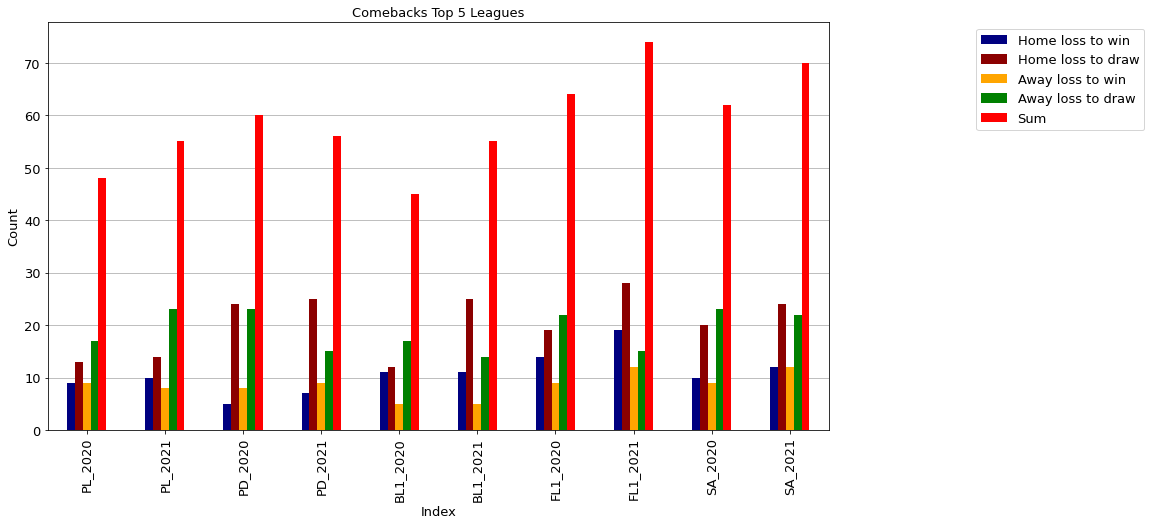

In [53]:
graph_colours = {"Home loss to win":"navy", "Home loss to draw":"darkred", "Away loss to win":"orange", "Away loss to draw":"green", "Sum":"red"}
ax = df_comebacks.plot.bar(figsize=(14,7.5), color = graph_colours, fontsize=fontsize, zorder=3)
ax.set_title("Comebacks Top 5 Leagues", fontsize=fontsize)
ax.set_xlabel("Index", fontsize=fontsize)
ax.set_ylabel("Count", fontsize=fontsize) 
# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
ax.yaxis.grid(True)

This plot shows that the most comebacks occured in Ligue 1 in 2021/22, followed by the Serie A in 2021/22. The most prevailing comeback scenario was the Home Team recovering from a losing position to draw the game, followed by the Away Team recovering from a losing position to draw the game, which is unsurprising. However, the more frequent scenario between these two varied between each league. 

The data also suggests that in most leagues there were more comebacks in 2021/22 than in 2020/21, especially in home games which could be explained by fans being at the games and encouraging their teams.

### Correlation

The correlation between goals scored by both teams at Full-Time and Half-Time is analysed to see if the home team or away team scored more goals in the second half

C:\Users\samly\AppData\Local\Temp\ipykernel_2728\163818733.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\163818733.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\163818733.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.append(values)
C:\Users\samly\AppData\Local\Temp\ipykernel_2728\163818733.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_numeric_values = df_numeric_values.app

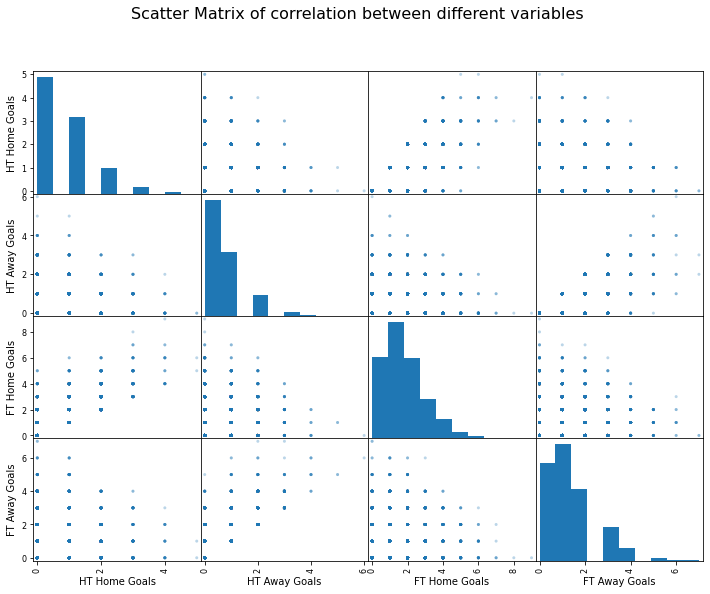

In [54]:
#Initialise the new DataFrame to store the values of the numeric variables
df_numeric_values = pd.DataFrame({})
for league in league_codes:
    for season in seasons:
    #Filter the numeric values from each artist in the artist DataFrame
        values = df_leagues[league]["matches"][season].filter(["HT Home Goals","HT Away Goals","FT Home Goals","FT Away Goals"], axis=1)
        df_numeric_values = df_numeric_values.append(values)
    
#Plot the scatter matrix
ax = scatter_matrix(df_numeric_values, figsize=(12,9), alpha=0.3)
plt.suptitle("Scatter Matrix of correlation between different variables", fontsize = fontsize+3);

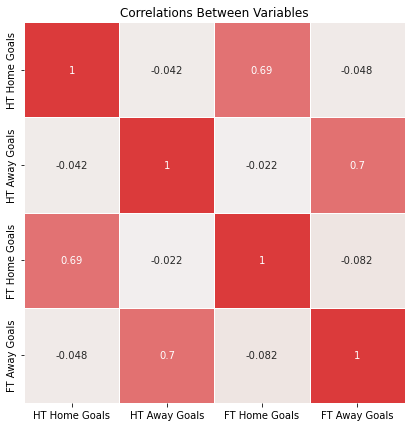

In [55]:
plot_heatmap("Correlations Between Variables", df_numeric_values, figsize=(11,7))

There is a stronger correlation between FT Away Goals and HT Away Goals (0.7) than FT Home Goals and HT Home Goals (0.69), this suggests that there are more goals scored by the home team in the second half.

# Conclusion

In this assignment we analysed the League Standing, Top Goalscorer, and Matches data for the Top 5 Football Leagues in Europe:Engligh Premier League; Spanish Primera Division; German Bundesliga; French Ligue 1; and Italian Serie A, over the 2020/21 (impacted by COVID-19) and the 2021/22 seasons.

We can conclude that:

- Not having fans in the stadium positively affected the home form of teams in the Italian Serie A, but negatively affected the home form of teams in the other 4 leagues.
- The Spanish Primera Division and the German Bundesliga are the most and least even leagues, repectively, when considering the disparity of points won per game between the team in first place and last place.
- The best goal scoring age is 29.
- More comebacks occured in 2021/22 than in 2020/21, and they are most frequent in the French Ligue 1.

The biggest difficulty in collecting this data was the limit imposed by Football Data API on 10 calls per minute but the time sleep() function was used to overcome this problem. A considerable level of data preprocessing was also required to merge the raw data into a single dataset for each datatype and league.

For further investigation and analysis of data the following could be considered:
1. Analysis of more seasons to further analyse the impact of fans attending games.
2. Analysis of more goal scorers rather than just the top 10 in each league to be able to investigate, fully, the highest scoring age.
3. More seasons of matches may allow you to build a predictive model for upcoming fixtures.